# Regresión lineal Multiple: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 

El objetivo es predecir los cargos a pagar basandonos en algunas caracteristicas del paciente 

## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [466]:
# Lo instalamos en nuestro ambiente local, en este caso trabajo en una ambiente de conda
# para instalarlo ejecutamos las siguientes lineas de codigo en el ambiente seleccionado:
#%pip install --upgrade pip setuptools==57.5.0
#%pip install regressors

In [467]:
# librerias
import pandas as pd
import seaborn as sns

In [468]:
# Estilos de las graficas
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [469]:
df = pd.read_csv('./insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Observamos cómo se distribuyen los datos de la variable a predecir.

In [470]:
# dimension del dataframe
print(df.shape)

(1338, 7)


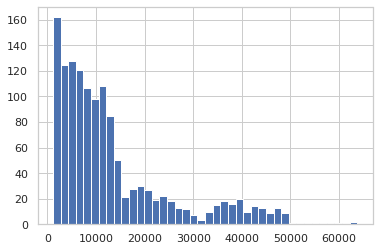

In [471]:
# Histograma de la variable objetivo (charges)
df.charges.hist(bins=40);

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [472]:
df[df.charges > 50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

In [473]:
# df con solo cargos menores a 50000
df = df[df.charges < 50000]

Vamos a crear una funcion que detecte valores atipicos de una variable especifica y devuelva un dataframe con el indice y los valores de los outliers 

In [474]:
def detect_outliers(x):
    
    Q3 = df[x].quantile(0.75)
    Q1 = df[x].quantile(0.25)
    IQR = Q3 - Q1
    
    superior = Q3 + (1.5 * IQR)
    inferior = Q3 - (1.5 * IQR)

    out_sup = df[df[x] > superior].index
    out_inf = df[df[x] < inferior].index

    outliers = {}
    for i in out_sup:
        outliers[i] = df.loc[i, x]
        
    for j in out_sup:
        outliers[i] = df.loc[j, x]
        
    size = len(outliers)
    
    df_outliers = pd.DataFrame(list(outliers.items()), columns=['Indice',x])
    return df_outliers
    

Probamos la funcion en la variable **bmi**

In [475]:
detect_outliers('bmi')

,Indice,bmi
0,116,49.06
1,286,48.07
2,401,47.52
3,847,50.38
4,860,47.60
5,1047,52.58
6,1088,47.74
7,1317,53.13


Verifiquemos que sean correctas los resultados de la funcion mediante el histograma de **bmi**

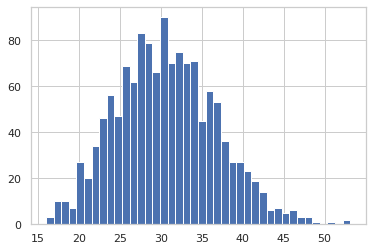

In [476]:
df.bmi.hist(bins=40);

Vemos que los valores de bmi mayores a 50 tienden a ser valores atipicos.

In [477]:
df[df['bmi'] > 50]

,age,sex,bmi,children,smoker,region,charges
847,23,male,50.38,1,no,southeast,2438.0552
1047,22,male,52.58,1,yes,southeast,44501.3982
1317,18,male,53.13,0,no,southeast,1163.4627


Observemos la distribucion edad

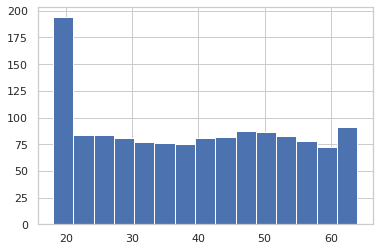

In [478]:
df.age.hist(bins=15);

Las edades estan distribuidas relativamente uniforme desde los 22 a los 60. Hay una gran cantidad de pacientes con edades entre los 18 y 21.

Observemos el histograma de los pacientes que fuman y no fuman

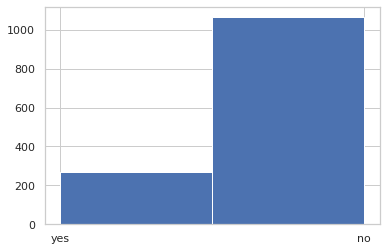

In [479]:
df.smoker.hist(bins=2);

La grafica nos indica que hay mas pacientes que no fuman de los que si fuman

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

In [480]:
# importamos libreria
import matplotlib.pyplot as plt

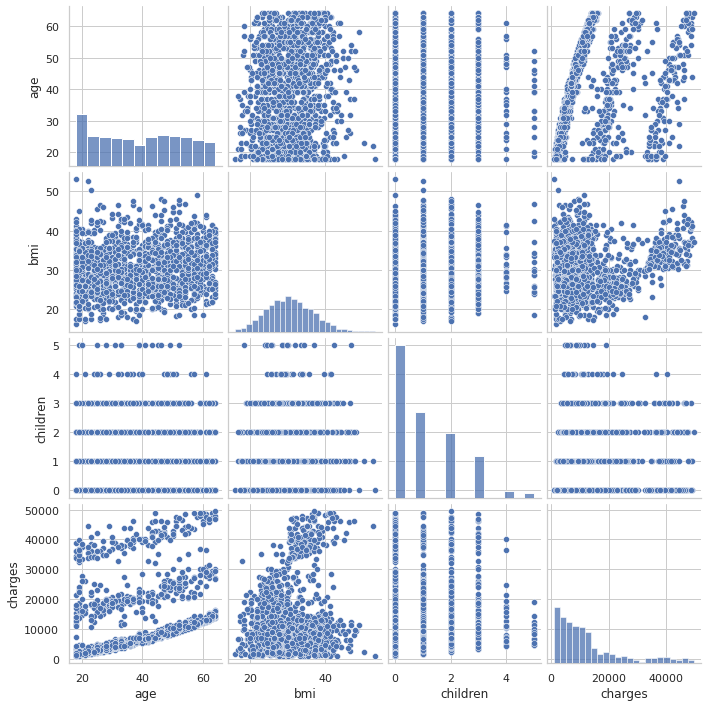

In [481]:
# creamos una matriz de graficos
sns.pairplot(df, height=2.5);

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

Ahora, creamos un mapa de calor de las variables

In [482]:
import numpy as np

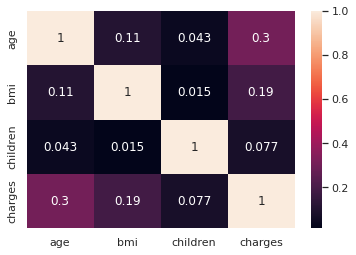

In [483]:
# agrupamos variables numericas
numeric_cols = ['age','bmi','children','charges']

# obtenemos los coeficientes de correlacion de las variables
cm = np.corrcoef(df[numeric_cols].values.T)

# Plot heat map
sns.heatmap(cm, annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols);


## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas para convertirlos en valores numericos. 


In [484]:
# pasamos las variables categoricas a numericas
pd.get_dummies(df, columns=['sex','smoker','region'])

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,1,1,0,0,1,0,0
1334,18,31.920,0,2205.98080,1,0,1,0,1,0,0,0
1335,18,36.850,0,1629.83350,1,0,1,0,0,0,1,0
1336,21,25.800,0,2007.94500,1,0,1,0,0,0,0,1


In [485]:
# papa eliminar las variables redundantes utilizamos el parametro drop_first
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Primer modelo 
Iniciamos con un modelo que contenga todas las variables.

In [486]:
# librerias

# libreria para escalar los datos
from sklearn.preprocessing import StandardScaler
# modelo de regresion lineal
from sklearn.linear_model import LinearRegression
# permite crear un dataset de prueba y de entrenamiento
from sklearn.model_selection import train_test_split 

In [487]:
# utiliza set para quitar las variables que no sean de interes

# variables predictoras 
X_cols = list(set(df.columns) - set(['charges']))

# variable objetivo
y_col = ['charges']

Vamos a crear una funcion que al pasarle la lista de variables predictoras y la variable objetivo nos arroje el modelo ya entrenado junto a las metricas

In [488]:
import sklearn.metrics as metrics
from regressors import stats

def Model_RL(X_cols, y_col, df):
    
    # definimos las variables a utlizar en el modelo
    X = df[X_cols].values
    y = df[y_col].values
    
    # creamos dos grupos de datos
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    # Estandarizamos los datos
    sc_x = StandardScaler().fit(X)
    sc_y = StandardScaler().fit(y)

    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)
    y_train = sc_y.transform(y_train)
    y_test = sc_y.transform(y_test)
    
    # Creacion del modelo
    model = LinearRegression()
    
    # Ajuste del modelo
    model.fit(X_train, y_train)
    
    # generamos una prediccion con datos de prueba
    y_pred = model.predict(X_test)
    
    # metricas del modelo
    print('======Metricas Principales========')
    # Error cuadratico medio
    mse = metrics.mean_squared_error(y_test, y_pred)

    # R cuadrado
    r2 = metrics.r2_score(y_test, y_pred)

    # mostramos resultados
    print('R Cuadrado: ',r2.round(4))
    print('MSE: ',mse.round(4))
    print('  ')
    
    # Resumen de todas las metricas
    # adecuamos el formato del intercepto
    model.intercept_ = model.intercept_[0]

    # convertimos los coeficientes del modelo en el formato adecuado
    model.coef_ = model.coef_.reshape(-1)
    
    # damos formato adecuado a los datos de prueba
    y_test = y_test.reshape(-1)
    
    # mostramos resultados
    print('======Summary========')

    # se pasa el modelo con los datos de prueba y el nombre de las columnas(X_cols)
    stats.summary(model, X_test, y_test, X_cols)
    print(' ')
    
    # teronamos los valores reales y de prediccion de la variable objetivo
    #return y_test, y_pred
    
    # Grafico de los residuales
    print('======Grafico de los Residuales========')
    # restamos los valores reales a los predichos con el formato adecuado
    residuals = np.subtract(y_test, y_pred.reshape(-1))
    
    # graficamos valores
    plt.scatter(y_pred, residuals)
    
    # graficamos linea espejo
    plt.axhline(y=0, color='Red', linestyle='-');
    

======Metricas Principales========
R Cuadrado:  0.7129
MSE:  0.2567
  
======Summary========
Residuals:
    Min      1Q  Median     3Q    Max
-2.0666 -0.1173  0.0799 0.2227 0.8929


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.007793    0.027951  -0.2788  0.780564
region_southwest -0.037096    0.031287  -1.1857  0.236592
smoker_yes        0.793566    0.029903  26.5380  0.000000
region_northwest -0.018898    0.032914  -0.5742  0.566242
children          0.041952    0.028470   1.4736  0.141549
sex_male         -0.000239    0.027948  -0.0086  0.993176
region_southeast -0.041473    0.033904  -1.2232  0.222105
age               0.328438    0.026888  12.2149  0.000000
bmi               0.169225    0.030367   5.5727  0.000000
---
R-squared:  0.71287,    Adjusted R-squared:  0.70578
F-statistic: 100.55 on 8 features
 
======Grafico de los Residuales========


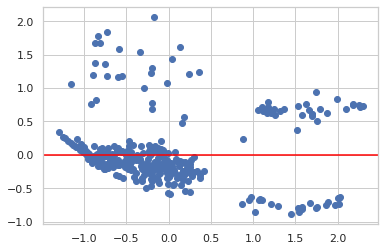

In [489]:
Model_RL(X_cols, y_col, df)

Para la metricas principales tenemos:
- Modelos con valores de R cuadrado arriba del 75% se considera bueno para usar en predicciones
- Modelos con R cuadrado mayor al 85% se consideran excelentes para prediccion
- Modelos con R cuadrado mayor al 90% se consideran prefectos
- Modelos con R cuadrado del 100% tienen problemas ya que pueden estar sobreajustado a los datos.
- Recordar que el valor de MSE proviene de los datos estandarizados el cual ronda entre -3 y 3. El valor de MSE de los datos reales tiende a ser mas pequeno 

Para el resumen de todas las metricas del modelo tenemos:
- Los valores de los coeficientes corresponden a la columna Estimate
- W0:Intercept, W1:region_northwest, W2:smoker_yes, ....
- Los valores de Std Error indica como cambia los valores de los coeficientes.
- Los p-values nos indica la importancia de la variable para el modelo.
- la R cuadrada ajustada siempre va a ser mas chica que la R cuadrada. Lo importante es ver que tan grande es la diferencia entre ambas. En este caso, como no hay una gran diferencia indica que no hay mayor problema al tener todas las variables en el modelo.

Para el grafico de residuales tenemos:
- Los valores se comparan con la linea del cero.
- La primer region indica que los valores predichos si se acercan a los valores reales.
- La segunda region indica que los valores predichos no son perfecto ya que estan un poco alejados del cero

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [490]:
# creamos una nueva copia del dataframe
df_second =df.copy()

In [491]:
# creamos una nueva variable: Edad elevada al cuadrado
df_second['age2'] = df_second.age**2

# creamos una variable que considere el sobrepeso
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)

# creamos una variable que combine el sobrepeso de una persona y su condicion de fumador
# ambas variables son un indicativo fuerte del incremento de los cargos medicos
df_second['sobrepeso_fumador'] = df_second.sobrepeso * df_second.smoker_yes

Creando el modelo

======Metricas Principales========
R Cuadrado:  0.8424
MSE:  0.1403
  
======Summary========
Residuals:
    Min     1Q  Median     3Q    Max
-2.0574 0.0613  0.1071 0.1403 1.4323


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000787    0.020817   0.0378  0.969866
region_southwest  -0.043501    0.025001  -1.7399  0.082798
smoker_yes         0.467791    0.027312  17.1279  0.000000
sobrepeso_fumador  0.490668    0.030474  16.1011  0.000000
region_northwest  -0.007729    0.023674  -0.3265  0.744265
children           0.074259    0.020411   3.6381  0.000318
sex_male          -0.012780    0.020830  -0.6135  0.539933
region_southeast  -0.040501    0.023558  -1.7192  0.086511
sobrepeso         -0.029988    0.031992  -0.9374  0.349258
age               -0.075075    0.114866  -0.6536  0.513832
age2               0.388363    0.113117   3.4333  0.000672
bmi                0.052908    0.030853   1.7149  0.087306
---
R-squared:  0.84235,    Adjusted R-

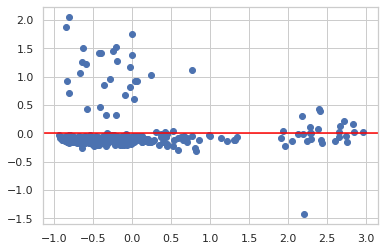

In [492]:
#----------------Seleccion de variables------------------------

# utiliza set para quitar las variables que no sean de interes

# variables predictoras 
X_cols2 = list(set(df_second.columns) - set(['charges']))

# variable objetivo
y_col2 = ['charges']

Model_RL(X_cols2, y_col2, df_second)

#----------------definimos las variables a utilizar en el modelo------------------------



Analizando el segundo modelo

## Tercer Modelo

Cuales son las variables que puedes dejar para este modelo?

Para ello, analizamos el p-valor y eliminamos todas aquellas mayores a .05. La razon es una funcionalidad estadistica donde el valor indica si la variable es verdaderamente cero o no cumple dicha suposicion y es diferente a cero.

======Metricas Principales========
R Cuadrado:  0.9399
MSE:  0.0618
  
======Summary========
Residuals:
    Min     1Q  Median     3Q    Max
-1.3809 0.0935  0.1278 0.1525 0.3247


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.015973    0.013678   1.1678  0.243734
region_southwest  -0.024688    0.013168  -1.8748  0.061697
sobrepeso_fumador  0.488261    0.016785  29.0888  0.000000
smoker_yes         0.452953    0.017524  25.8472  0.000000
age2               0.324240    0.013545  23.9374  0.000000
children           0.070904    0.014743   4.8094  0.000002
---
R-squared:  0.93990,    Adjusted R-squared:  0.93898
F-statistic: 1022.83 on 5 features
 
======Grafico de los Residuales========


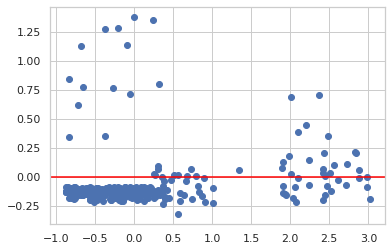

In [495]:
#----------------Seleccion de variables------------------------

# variables predictoras 
X_cols3 = ['region_southwest','sobrepeso_fumador','smoker_yes','age2','children']

# variable objetivo
y_col3 = ['charges']

Model_RL(X_cols3, y_col3, df_second)

#----------------definimos las variables a utilizar en el modelo------------------------




## Ajuste del Tercer Modelo

Del summary anterior, vemos que las variables region_southwest e intercept no estan contribuyendo de forma relevante al modelo por lo que eliminamos ambas variables para ajustar aun mas el modelo

In [ ]:
#----------------Seleccion de variables------------------------

# variables predictoras 
X_cols = ['sobrepeso_fumador','smoker_yes','age2','children']

# variable objetivo
y_col = ['charges']

#----------------definimos las variables a utilizar en el modelo------------------------

# Variables predictoras
X=df_second[X_cols].values

# Variable objetivo
y = df_second[y_col].values

#---------------creamos dos conjuntos de datos: de prueba y de entrenamiento------------------

X_train, X_test, y_train, y_test = train_test_split(X,y)

# Estandarizamos los datos
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

#----------------------creamos el modelo---------------------

# modificamos el parametro del intercepto como falso
model = LinearRegression(fit_intercept=False)

# ajustamos el modelos a los datos de entrenamiento
model.fit(X_train, y_train)

# generamos una prediccion con los datos de prueba
y_pred = model.predict(X_test)

# mostramos cantidad de predicciones y numero de registros
y_pred.shape


In [ ]:
# evaluando las metricas de los valores reales con los valores predichos

# Error cuadratico medio
mse = metrics.mean_squared_error(y_test, y_pred)

# R cuadrado
r2 = metrics.r2_score(y_test, y_pred)

# mostramos resultados
print('R Cuadrado: ',r2.round(4))
print('MSE: ',mse.round(4))

In [ ]:
# omitimos este analisis debido a que no tenemos el intercepto
#model.intercept_ = model.intercept_[0]

# obtener los coeficientes del modelo en el formato adecuado
model.coef_ = model.coef_.reshape(-1)

# damos formato adecuado a los datos de prueba
y_test = y_test.reshape(-1)

# mostramos resultados
print('======Summary========')

# se pasa el modelo con los datos de prueba y el nombre de las columnas(X_cols)
stats.summary(model, X_test, y_test, X_cols)


In [ ]:
# restamos valores reales con los predichos. Damos formato adecuado
# a los valores predichos
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='Red', linestyle='-');